In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import json
from typing import Tuple, Callable
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras import optimizers
from keras.models import Sequential
from keras import backend as K
from keras import metrics
from keras.applications import InceptionV3, MobileNetV2
from keras.engine.training import Model
from keras import layers
from keras import models

In [2]:
train_df = pd.read_csv('clean_train_data.csv', index_col= 0)
test_df = pd.read_csv('clean_test_data.csv', index_col= 0)
names_df = pd.read_csv('names.csv',header= None)
names_df.columns = ['model_name']
names_df.head()

,model_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [3]:
img_width = 299
img_height = 299
num_channels = 3
num_classes = 196
batch_size = 64

train_dir = '../Capstone 2 Stanford Car Classification/car_data/train'
test_dir = '../Capstone 2 Stanford Car Classification/car_data/test'
datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range= 40,
                                   width_shift_range= 0.2,
                                   height_shift_range= 0.2,
                                   shear_range= 0.2,
                                   zoom_range= 0.2,
                                   horizontal_flip= True,
                                   fill_mode= 'nearest')

classList = names_df.model_name.tolist()

In [4]:
train_generator = datagen.flow_from_directory(directory= train_dir,
                                            target_size= (img_width,img_height),
                                            classes= classList,
                                            class_mode= 'categorical',
                                            batch_size= batch_size)

train_images_count = len(train_generator.filenames)

Found 8103 images belonging to 196 classes.


In [5]:
test_generator = datagen.flow_from_directory(directory= test__dir,
                                            target_size= (img_width,img_height),
                                            classes= classList,
                                            class_mode= 'categorical',
                                            batch_size= batch_size)

test_images_count = len(train_generator.filenames)

Found 8000 images belonging to 196 classes.


In [6]:
conv_base = InceptionV3(weights= 'imagenet',
                    include_top= False,
                    pooling= 'avg')

In [7]:
pred_layer_config = {
    'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
                           'config': {
                               'distribution': 'uniform',
                               'mode': 'fan_avg',
                               'scale': 1.0,
                               'seed': 8}
                          },
    'kernel_regularizer': None,
    'name': 'predictions',
    'trainable': True,
    'units': 196,
    'use_bias': True}

model = Sequential()
model.add(conv_base)
model.add(Dropout(0.5, seed=21))
model.add(Dense(**pred_layer_config))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 190
This is the number of trainable weights before freezing the conv base: 2


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 401,604
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
def top_5_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [10]:
optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_5_acc])

In [20]:
history = model.fit_generator(train_generator,
                            steps_per_epoch= 8103 // batch_size,
                            epochs=10,
                            validation_data=test_generator,
                            validation_steps= 8000 // batch_size)

Epoch 1/10
126/126 [==============================] - 6028s 48s/step - loss: 5.3357 - categorical_accuracy: 0.0234 - top_5_acc: 0.0776 - val_loss: 4.7488 - val_categorical_accuracy: 0.0373 - val_top_5_acc: 0.1408
Epoch 2/10
126/126 [==============================] - 5912s 47s/step - loss: 4.6541 - categorical_accuracy: 0.0684 - top_5_acc: 0.2036 - val_loss: 4.5665 - val_categorical_accuracy: 0.0621 - val_top_5_acc: 0.1975
Epoch 3/10
126/126 [==============================] - 5928s 47s/step - loss: 4.2897 - categorical_accuracy: 0.1121 - top_5_acc: 0.2862 - val_loss: 4.5071 - val_categorical_accuracy: 0.0695 - val_top_5_acc: 0.2221
Epoch 4/10
126/126 [==============================] - 6097s 48s/step - loss: 4.0365 - categorical_accuracy: 0.1440 - top_5_acc: 0.3486 - val_loss: 4.3821 - val_categorical_accuracy: 0.0900 - val_top_5_acc: 0.2486
Epoch 5/10
126/126 [==============================] - 6396s 51s/step - loss: 3.8541 - categorical_accuracy: 0.1630 - top_5_acc: 0.3917 - val_loss: 4

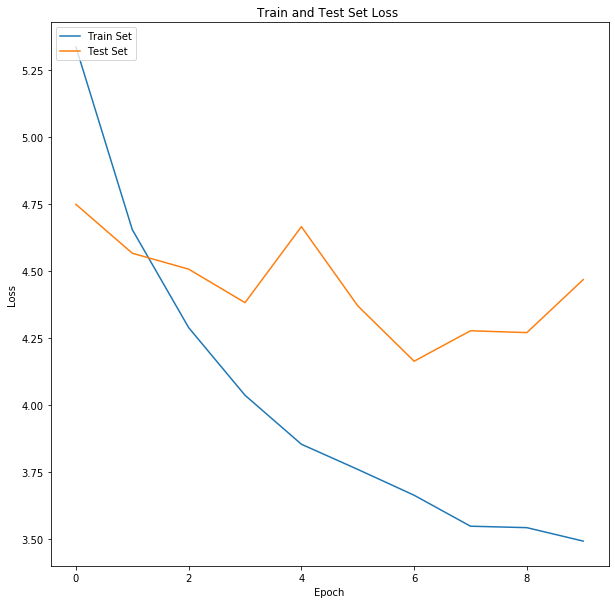

In [38]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['loss'], label='Train Set')
_ = plt.plot(history.history['val_loss'], label='Test Set')
_ = plt.title('Train and Test Set Loss ')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

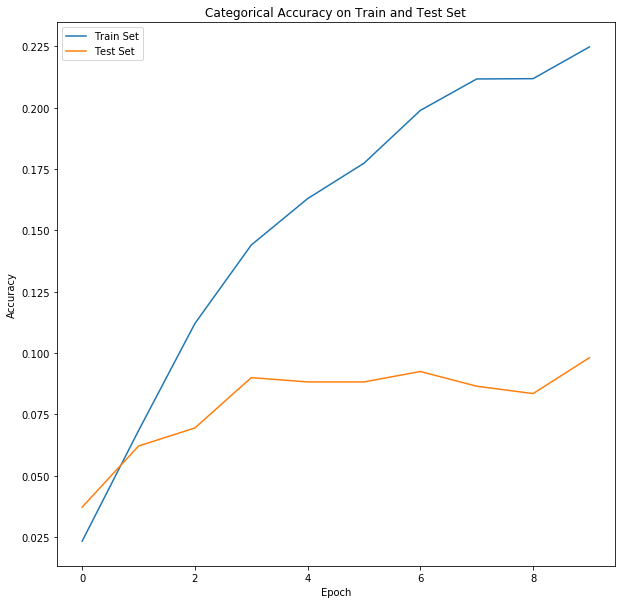

In [40]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['categorical_accuracy'], label='Train Set')
_ = plt.plot(history.history['val_categorical_accuracy'], label='Test Set')
_ = plt.title('Categorical Accuracy on Train and Test Set')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

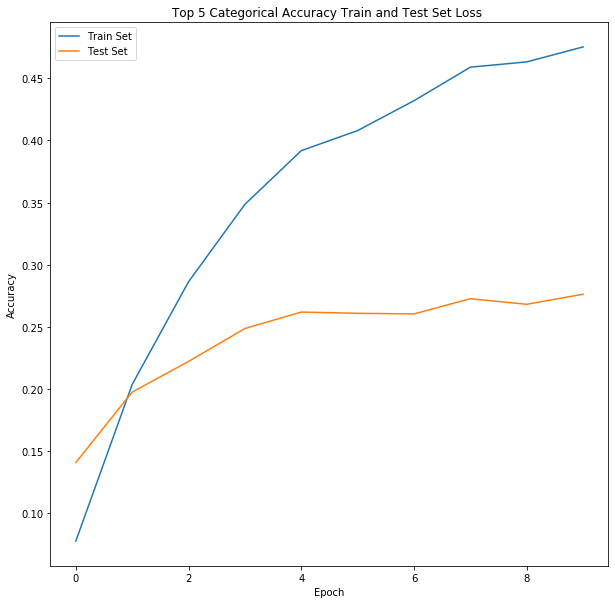

In [39]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['top_5_acc'], label='Train Set')
_ = plt.plot(history.history['val_top_5_acc'], label='Test Set')
_ = plt.title('Top 5 Categorical Accuracy Train and Test Set Loss ')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

In [15]:
conv_base.trainable = True
set_trainable = False
layerlist = ['conv2d_71', 'batch_normalization_71',
            'conv2d_72', 'batch_normalization_72',
            'conv2d_73', 'batch_normalization_73',
            'conv2d_74', 'batch_normalization_74',
            'conv2d_75', 'batch_normalization_75',
            'conv2d_76', 'batch_normalization_76'
            'conv2d_77', 'batch_normalization_77',
            'conv2d_78', 'batch_normalization_78',
            'conv2d_79', 'batch_normalization_79',
            'conv2d_80', 'batch_normalization_80',
            'conv2d_81', 'batch_normalization_81',
            'conv2d_82', 'batch_normalization_82',
            'conv2d_83', 'batch_normalization_83',
            'conv2d_84', 'batch_normalization_84',
            'conv2d_85', 'batch_normalization_85'
            'conv2d_86', 'batch_normalization_86',
            'conv2d_87', 'batch_normalization_86',
            'conv2d_88', 'batch_normalization_88',
            'conv2d_89', 'batch_normalization_89',
            'conv2d_90', 'batch_normalization_90',
            'conv2d_91', 'batch_normalization_90',
            'conv2d_92', 'batch_normalization_92',
            'conv2d_93', 'batch_normalization_93',
            'conv2d_94', 'batch_normalization_94']

for layer in conv_base.layers:
    if layer.name in layerlist:
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
        
    else:
        layer.trainable = False

print('This is the number of trainable weights after limited freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after limited freezing the conv base: 50


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 20,507,364
Trainable params: 11,516,484
Non-trainable params: 8,990,880
_________________________________________________________________


/Users/sayantanchattopadhyay/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_5_acc])

history = model.fit_generator(train_generator,
                            steps_per_epoch= 8103 // batch_size,
                            epochs= 15,
                            validation_data=test_generator,
                            validation_steps= 8000 // batch_size)

Epoch 1/15
126/126 [==============================] - 7368s 58s/step - loss: 2.7456 - categorical_accuracy: 0.3183 - top_5_acc: 0.6320 - val_loss: 2.6492 - val_categorical_accuracy: 0.2866 - val_top_5_acc: 0.6126
Epoch 2/15
126/126 [==============================] - 7482s 59s/step - loss: 1.9525 - categorical_accuracy: 0.4754 - top_5_acc: 0.7943 - val_loss: 1.6553 - val_categorical_accuracy: 0.4277 - val_top_5_acc: 0.7559
Epoch 3/15
126/126 [==============================] - 7347s 58s/step - loss: 1.5322 - categorical_accuracy: 0.5715 - top_5_acc: 0.8665 - val_loss: 1.6422 - val_categorical_accuracy: 0.5064 - val_top_5_acc: 0.8154
Epoch 4/15
126/126 [==============================] - 7283s 58s/step - loss: 1.2498 - categorical_accuracy: 0.6424 - top_5_acc: 0.8979 - val_loss: 2.0648 - val_categorical_accuracy: 0.5421 - val_top_5_acc: 0.8372
Epoch 5/15
126/126 [==============================] - 7333s 58s/step - loss: 1.0305 - categorical_accuracy: 0.6942 - top_5_acc: 0.9362 - val_loss: 1

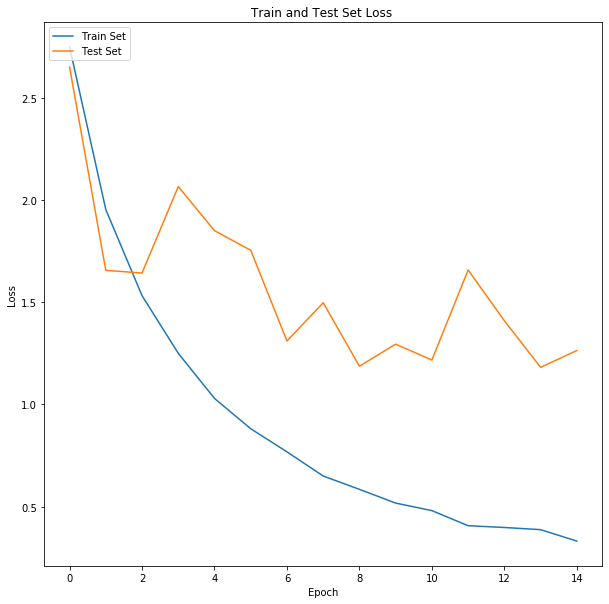

In [18]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['loss'], label='Train Set')
_ = plt.plot(history.history['val_loss'], label='Test Set')
_ = plt.title('Train and Test Set Loss ')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

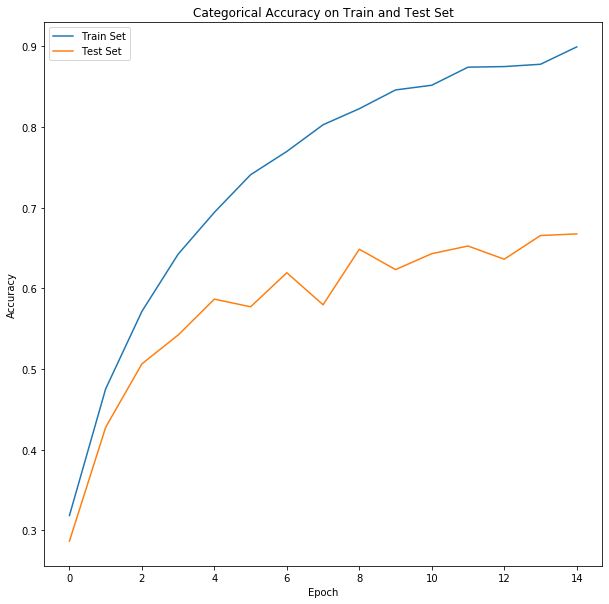

In [19]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['categorical_accuracy'], label='Train Set')
_ = plt.plot(history.history['val_categorical_accuracy'], label='Test Set')
_ = plt.title('Categorical Accuracy on Train and Test Set')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

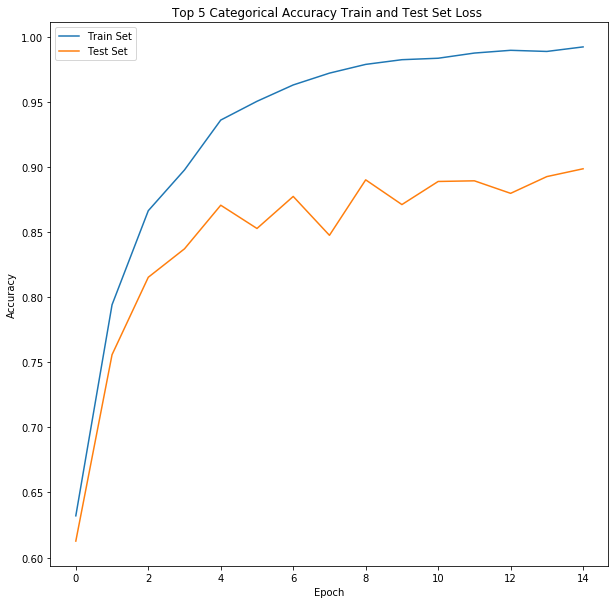

In [20]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['top_5_acc'], label='Train Set')
_ = plt.plot(history.history['val_top_5_acc'], label='Test Set')
_ = plt.title('Top 5 Categorical Accuracy Train and Test Set Loss ')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

In [62]:
def get_mobilenetv2(_num_classes) -> Tuple[Model, Model, int, Callable]:
    
    initial_model: Model = MobileNetV2(weights= 'imagenet', alpha= 1.4, include_top= False,
                                       input_shape= (224, 224, 3))

    initial_model.trainable = True
    
    for i, layer in enumerate(initial_model.layers):
        layer.trainable = True


    initial_model_output = initial_model.output
    x = layers.GlobalAveragePooling2D()(initial_model_output)
    x = layers.Dense(1024, activation='relu')(x)
    predictions = layers.Dense(_num_classes, activation='softmax')(x)

    model = Model(initial_model.input, predictions)

    return model, initial_model, image_size, keras.applications.mobilenet_v2.preprocess_input

In [46]:
def get_callbacks_list(_early_stopping_patience, _reduce_lr_on_plateau_factor, _reduce_lr_on_plateau_patience):
    return [keras.callbacks.EarlyStopping(monitor= 'val_categorical_accuracy',patience= _early_stopping_patience),
        keras.callbacks.ModelCheckpoint(verbose= 1,
                                        filepath= 'best_model.h5',
                                        monitor= 'val_loss',
                                        save_best_only= True),
        keras.callbacks.ReduceLROnPlateau(verbose= 1,
                                        monitor= 'val_loss',
                                        factor= _reduce_lr_on_plateau_factor,
                                        patience =_reduce_lr_on_plateau_patience),]

In [48]:
init_lr = 0.01
momentum = 0.9
epochs = 25
optimazer = keras.optimizers.SGD(lr=init_lr, momentum=momentum)
early_stopping_patience = 10
reduce_lr_on_plateau_factor = 0.2
reduce_lr_on_plateau_patience = 3
model_function = get_mobilenetv2
num_classes = len(os.listdir(train_dir))
model, conv_base, image_size, preprocess_function = model_function(196)

In [49]:
train_image_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_function,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_image_datagen.flow_from_directory(train_dir,
                                                        target_size= (image_size, image_size),
                                                        batch_size= batch_size,
                                                        class_mode= 'categorical')

train_images_count = len(train_generator.filenames)

Found 8144 images belonging to 196 classes.


In [50]:
validation_image_datagen = ImageDataGenerator(preprocessing_function=preprocess_function)
validation_generator = validation_image_datagen.flow_from_directory(test_dir,
                                                                    target_size= (image_size, image_size),
                                                                    batch_size= batch_size,
                                                                    class_mode= 'categorical')
                                                                    
validation_images_count = len(validation_generator.filenames)

Found 8041 images belonging to 196 classes.


In [51]:
model.compile(loss= 'categorical_crossentropy', optimizer= optimazer, metrics= [metrics.categorical_accuracy, top_5_acc])

In [53]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 48) 1296        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 48) 192         Conv1[0][0]                      
____________________________________________________________________________________________

In [52]:
train_steps = len(train_generator.filenames) // batch_size
validation_steps = len(validation_generator.filenames) // batch_size
history = model.fit_generator(train_generator,
                            steps_per_epoch= train_steps,
                            epochs= epochs,
                            validation_data= validation_generator,
                            validation_steps= validation_steps,
                            callbacks= get_callbacks_list(early_stopping_patience, reduce_lr_on_plateau_factor, reduce_lr_on_plateau_patience))

validation_score = model.evaluate_generator(validation_generator, steps= validation_steps)
print('Validation loss: ', validation_score[0])
print('Validation acc:  ', validation_score[1])

Epoch 1/25
127/127 [==============================] - 8762s 69s/step - loss: 4.8044 - categorical_accuracy: 0.0489 - top_5_acc: 0.1525 - val_loss: 6.2711 - val_categorical_accuracy: 0.0284 - val_top_5_acc: 0.1000

Epoch 00001: val_loss improved from inf to 6.27111, saving model to best_model.h5
Epoch 2/25
127/127 [==============================] - 8414s 66s/step - loss: 3.0042 - categorical_accuracy: 0.2687 - top_5_acc: 0.5741 - val_loss: 5.4241 - val_categorical_accuracy: 0.0790 - val_top_5_acc: 0.2448

Epoch 00002: val_loss improved from 6.27111 to 5.42412, saving model to best_model.h5
Epoch 3/25
127/127 [==============================] - 8259s 65s/step - loss: 1.9579 - categorical_accuracy: 0.4750 - top_5_acc: 0.7962 - val_loss: 9.4749 - val_categorical_accuracy: 0.0184 - val_top_5_acc: 0.0923

Epoch 00003: val_loss did not improve from 5.42412
Epoch 4/25
127/127 [==============================] - 8171s 64s/step - loss: 1.3765 - categorical_accuracy: 0.6095 - top_5_acc: 0.8882 - va

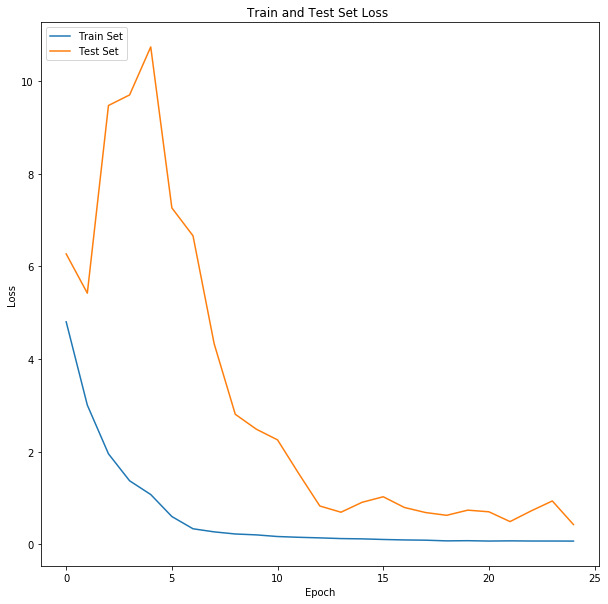

In [54]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['loss'], label='Train Set')
_ = plt.plot(history.history['val_loss'], label='Test Set')
_ = plt.title('Train and Test Set Loss ')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

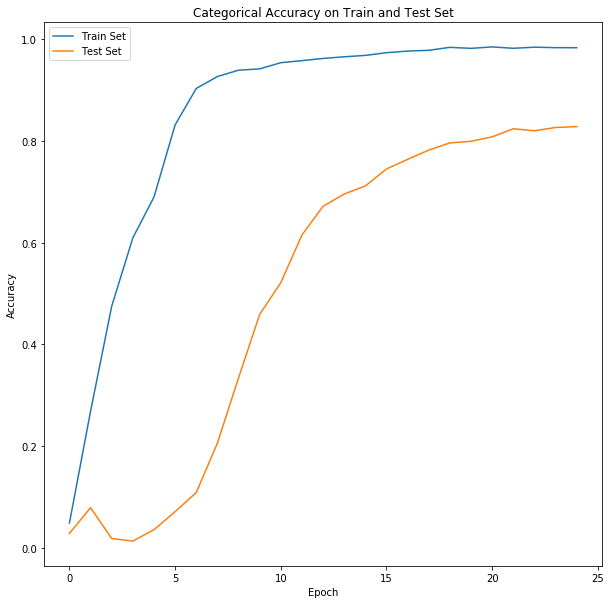

In [55]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['categorical_accuracy'], label='Train Set')
_ = plt.plot(history.history['val_categorical_accuracy'], label='Test Set')
_ = plt.title('Categorical Accuracy on Train and Test Set')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

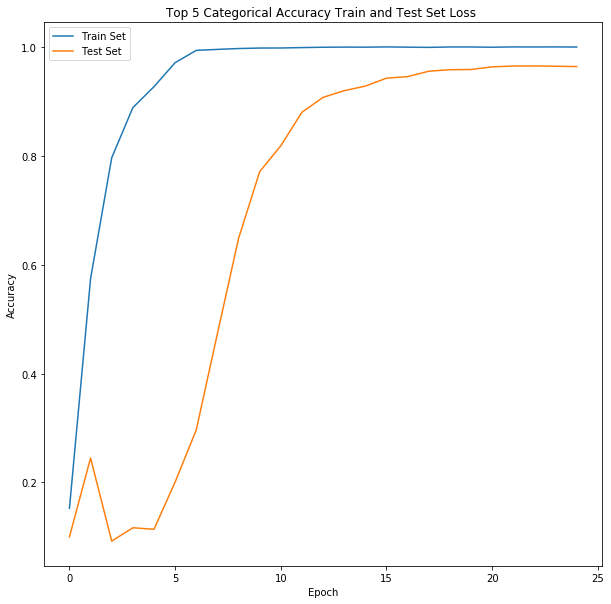

In [56]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(history.history['top_5_acc'], label='Train Set')
_ = plt.plot(history.history['val_top_5_acc'], label='Test Set')
_ = plt.title('Top 5 Categorical Accuracy Train and Test Set Loss ')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(loc="upper left")
_ = plt.show()

In [60]:
json_model = model.to_json()
with open('mobilenetv2.json', 'w') as json_file:
    json.dump(json_model,json_file)